In [23]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

import re
from urllib.request import urlopen
from urllib.parse import urlparse
from urllib.error import HTTPError

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from settings import *

## Read Data

In [25]:
query = """
select *
from 
(select id, body, doc_type
from document
where doc_type = 'web'
limit 10000) t1
UNION
(select id, body, doc_type
from document
where doc_type = 'twitter'
limit 10000)
"""


documents = queryDB(query, 'smeros', '', 'sciArticles')
documents = documents.set_index('id')

In [26]:
def extractLinks(documents):

    urlRegex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    
    documents = documents.copy(deep=True)
    documents['body'] = documents['body'].apply(lambda x: re.findall(urlRegex, x)).to_frame()
    documents.rename(columns={'body': 'urls'}, inplace=True)
    
    return documents
extractLinks(documents)

,urls,doc_type
id,,
cc56e45a-45d0-11e5-afcc-42010af074fc,[http://t.co/zKAA55PckV],twitter
f80a8252-52fd-11e5-b5bc-42010af0793b,[https://t.co/92yogHqaWQ],twitter
80d2830e-57cd-11e5-aaeb-42010af074fc,[],web
6e945790-65cf-11e5-b6fd-42010af0793b,[],web
a1c1124a-4da7-11e5-99dd-42010af074fc,[http://www.cdc.gov/mmwr/preview/mmwrhtml/mm60...,web
baf26542-5375-11e5-a03f-42010af0793b,[],web
a98d4c78-52f7-11e5-b0b4-42010af0793b,[http://t.co/ZBIjKOkf],twitter
f2381fca-45c3-11e5-afcc-42010af074fc,"[http://t.co/5cziPa99ar, http://t.co/QwoBYJwvkM]",twitter
e36fdd74-4b50-11e5-a1fd-42010af074fc,[],web


In [53]:
def countLinks(documents):
    documents = documents.copy(deep=True)
    documents = extractLinks(documents)
    documents['urls'] = documents['urls'].apply(lambda x: len(x) if len(x)<linkLimit else "≥"+str(linkLimit))
    return documents.groupby(['doc_type','urls']).size()

def plotCountLinks(documents):
    count = countLinks(documents)
    docs = {}
    for doc_type in count.index.levels[0]:
        urls=[]
        for urlNum in count.index.levels[1]:
            urls.append(count.get((doc_type, urlNum),0))
        docs[doc_type]=urls

    
    both=pd.DataFrame(docs, index=count.index.levels[1])
    twitter=both['twitter'][lambda x: x!=0]
    web=both['web'][lambda x: x!=0]
 
    return both, twitter, web

bothCount, twitterCount, webCount = plotCountLinks(documents)

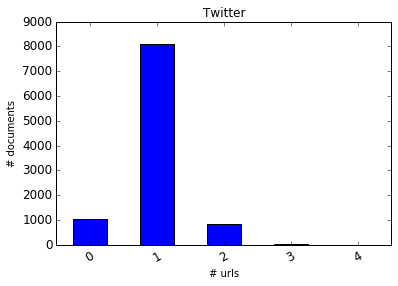

In [54]:
plt.xticks(rotation=70)
ax = twitterCount.plot.bar(fontsize=12, color='b', title='Twitter')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_xlabel("# urls")
ax.set_ylabel("# documents")

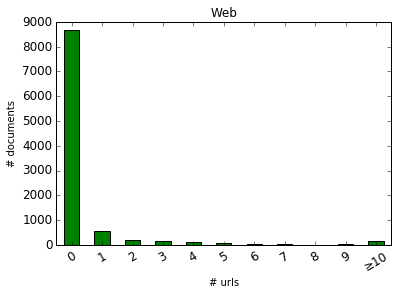

In [55]:
ax = webCount.plot.bar(fontsize=12, color='g', title='Web')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_xlabel("# urls")
ax.set_ylabel("# documents")

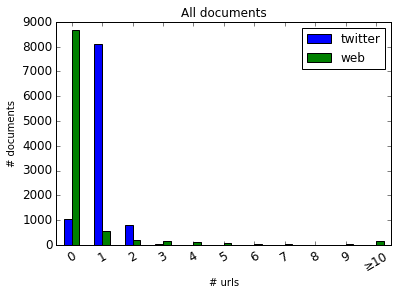

In [56]:
ax = bothCount.plot.bar(fontsize=12, color='bg', title='All documents')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_xlabel("# urls")
ax.set_ylabel("# documents")

In [73]:
def flattenLinks(documents):
    documents = documents.copy(deep=True)
    documents = extractLinks(documents)
    
    documents = pd.DataFrame([(row[0], link, row[2]) for row in documents.itertuples() for link in row[1]], columns=['id', 'link', 'doc_type'])
    
    if (removeDuplicateLinks):
        documents = documents.drop_duplicates
        
    return documents
    
flattenLinks(documents)

<bound method DataFrame.drop_duplicates of                                          id                                               link doc_type
0      cc56e45a-45d0-11e5-afcc-42010af074fc                             http://t.co/zKAA55PckV  twitter
1      f80a8252-52fd-11e5-b5bc-42010af0793b                            https://t.co/92yogHqaWQ  twitter
2      a1c1124a-4da7-11e5-99dd-42010af074fc  http://www.cdc.gov/mmwr/preview/mmwrhtml/mm600...      web
3      a1c1124a-4da7-11e5-99dd-42010af074fc            http://www.cdc.gov/cholesterol/faqs.htm      web
4      a1c1124a-4da7-11e5-99dd-42010af074fc        http://www.ncbi.nlm.nih.gov/pubmed/21631511      web
5      a1c1124a-4da7-11e5-99dd-42010af074fc                                http://www.aarp.org      web
6      a1c1124a-4da7-11e5-99dd-42010af074fc                          http://www.oregonlive.com      web
7      a1c1124a-4da7-11e5-99dd-42010af074fc                               http://www.heart.org      web
8      a98d4c78-52f7-

In [72]:
def resolveURLs(documents):

    documents = documents.copy(deep=True)
    documents = flattenLinks(documents)

    resolvedURLs = pd.DataFrame
    unresolvedURLs = pd.DataFrame

#write a function for resolving url and apply it to the column of 'documents' df.
#     for url in urls:
#         try:
#             resolvedURL = urlopen(url,timeout=10).geturl()

#             if(urlparse(resolvedURL).netloc.endswith('.ly')):
#                 print('not resolved: ' + url)
#                 unresolvedURLs.append(url)
#                 continue

#             print ('resolved: ' + resolvedURL)
#             resolvedURLs.append(resolvedURL)
#         except HTTPError as e:
#             print (e.code)
#             print('not resolved: ' + url)
#             resolvedURLs.append('DeadLink')
    #return [session.head(url, allow_redirects=True).url for url in urls]



    return documents

#urls = urls.apply(lambda x: resolveURLs(x))


#Checks resolvability of URLs
#resolvableURLs = urls.apply(pd.Series).applymap(lambda x: None if pd.isnull(x) else requests.get(x, verify=False).status_code==200)
#resolvableURLs = pd.Series(np.logical_or.reduce(resolvableURLs, axis=1), name="hasResolvableURLs")
#print (resolvableURLs.shape)




resolveURLs(documents)

<bound method DataFrame.drop_duplicates of                                          id                                               link doc_type
0      cc56e45a-45d0-11e5-afcc-42010af074fc                             http://t.co/zKAA55PckV  twitter
1      f80a8252-52fd-11e5-b5bc-42010af0793b                            https://t.co/92yogHqaWQ  twitter
2      a1c1124a-4da7-11e5-99dd-42010af074fc  http://www.cdc.gov/mmwr/preview/mmwrhtml/mm600...      web
3      a1c1124a-4da7-11e5-99dd-42010af074fc            http://www.cdc.gov/cholesterol/faqs.htm      web
4      a1c1124a-4da7-11e5-99dd-42010af074fc        http://www.ncbi.nlm.nih.gov/pubmed/21631511      web
5      a1c1124a-4da7-11e5-99dd-42010af074fc                                http://www.aarp.org      web
6      a1c1124a-4da7-11e5-99dd-42010af074fc                          http://www.oregonlive.com      web
7      a1c1124a-4da7-11e5-99dd-42010af074fc                               http://www.heart.org      web
8      a98d4c78-52f7-

In [ ]:


#tweets1 = extractURLs(tweets)

print (tweets1['urls'][0:10])

#conn.setopt(pycurl.URL, "http://t.co/yzUy11usmg")
#conn.setopt(pycurl.URL, "http://t.co/cEVKs7ewVN")

In [ ]:
print (urls)